In [1]:
%matplotlib inline
import sys
sys.path.append('../../src')

from scripts.utils import maybe_makedirs
import matplotlib.pyplot as plt

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from torch.utils.data import Dataset, DataLoader

import numpy as np
import os
import pickle
import torch
import pickle
import stlcg

In [2]:
import matplotlib 
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [3]:
#### Settings ####
fig_dir = "figs/pSTL"
data_dir = "data/pSTL"
maybe_makedirs(fig_dir)
maybe_makedirs(data_dir)

### loading generated data.
Data was generated in matlab

In [4]:
import scipy.io
mat = scipy.io.loadmat(data_dir + "/clustering_data.mat")
ys_ = mat['ys']
ys = np.zeros(ys_.shape)
ys[:,:] = np.fliplr(ys_)     # flipped inputs to be ready for stlcg package
t = mat['T'][0,:]
N = ys.shape[0]

Text(0.5, 1.0, 'Dataset of step responses')

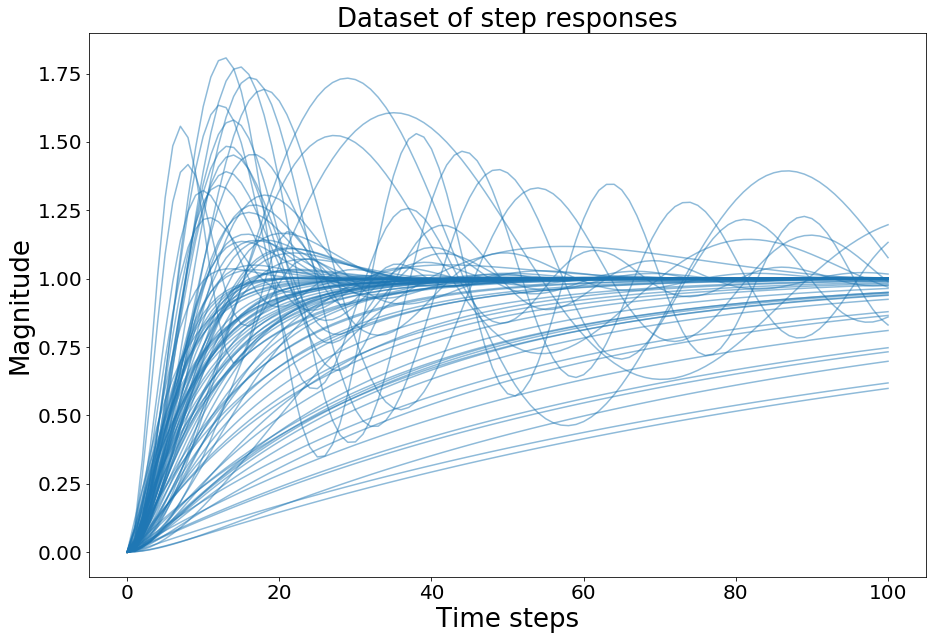

In [9]:
fs = 26
plt.figure(figsize=(15,10))
plt.plot(ys_[:100,:].T, c='#1f77b4', alpha=0.5)
plt.xlabel("Time steps", fontsize=fs)
plt.ylabel("Magnitude", fontsize=fs)
plt.title("Dataset of step responses", fontsize=fs)

In [17]:
max_epoch = 1000
lr = 0.005

## final value/settling
$$ \phi_1 =\square_{[50,100]}\, \| s - 1\| < \epsilon_1 \quad \text{(final value)} $$

### cuda

In [19]:
y = torch.as_tensor(ys).float().unsqueeze(-1).cuda()
s = stlcg.Expression('s', torch.abs(y - 1).cuda())
ϵ = torch.as_tensor(np.zeros([N, 1, 1])).float().cuda().requires_grad_(True)
ϕ = stlcg.Always(subformula=(s < ϵ).cuda(), interval=[50, 100]).cuda()

for epoch in range(max_epoch):

    loss = torch.relu(-ϕ.robustness(s).squeeze()).sum()
    loss.backward()

    with torch.no_grad():
        ϵ -= lr* ϵ.grad

    if epoch % 100 == 0:
        print("%i  loss: %.3f"%(epoch,loss.cpu().detach().numpy()))

    ϵ.grad.zero_()
    if loss == 0:
        print("%i  loss: %.3f"%(epoch, loss.cpu().detach().numpy()))
        break

0  loss: 49.955
100  loss: 5.546
  loss: 0.000


### cpu

In [25]:
y = torch.as_tensor(ys).float().unsqueeze(-1)
s = stlcg.Expression('s', torch.abs(y - 1))
ϵ = torch.as_tensor(np.zeros([N, 1, 1])).float().requires_grad_(True)
ϕ = stlcg.Always(subformula=(s < ϵ), interval=[50, 100])

for epoch in range(max_epoch):

    loss = torch.relu(-ϕ.robustness(s).squeeze()).sum()
    loss.backward()

    with torch.no_grad():
        ϵ -= lr* ϵ.grad

    if epoch % 100 == 0:
        print("%i  loss: %.3f"%(epoch,loss.cpu().detach().numpy()))

    ϵ.grad.zero_()
    if loss == 0:
        print("%i  loss: %.3f"%(epoch, loss.cpu().detach().numpy()))
        break


0  loss: 49.955
100  loss: 5.546
196  loss: 0.000


In [27]:
np.save(data_dir + "/final_value_stlcg.npy", ϵ.squeeze().detach().numpy())

## overshoot
$$ \phi_2 = \square \, s < \epsilon_2 \quad \text{(peak value)} $$

### cuda

In [24]:
y = torch.as_tensor(ys).float().unsqueeze(-1).cuda()
s = stlcg.Expression('s', y)
ϵ = torch.as_tensor(np.zeros([N, 1, 1])).float().cuda().requires_grad_(True)
ϕ = stlcg.Always(subformula=(s < ϵ)).cuda()


for epoch in range(max_epoch):

    loss = torch.relu(-ϕ.robustness(s).squeeze()).sum()
    loss.backward()

    with torch.no_grad():
        ϵ -= lr* ϵ.grad
        
    if epoch % 100 == 0:
        print("%i  loss: %.3f"%(epoch,loss.cpu().detach().numpy()))

    ϵ.grad.zero_()
    if loss == 0:
        print("%i  loss: %.3f"%(epoch, loss.cpu().detach().numpy()))
        break

0  loss: 546.461
100  loss: 297.922
200  loss: 60.359
300  loss: 9.716
398  loss: 0.000


### cpu

In [28]:
y = torch.as_tensor(ys).float().unsqueeze(-1)
s = stlcg.Expression('s', y)
ϵ = torch.as_tensor(np.zeros([N, 1, 1])).float().requires_grad_(True)
ϕ = stlcg.Always(subformula=(s < ϵ))
for epoch in range(max_epoch):

    loss = torch.relu(-ϕ.robustness(s).squeeze()).sum()
    loss.backward()

    with torch.no_grad():
        ϵ -= lr* ϵ.grad
        
    if epoch % 100 == 0:
        print("%i  loss: %.3f"%(epoch,loss.cpu().detach().numpy()))

    ϵ.grad.zero_()
    if loss == 0:
        print("%i  loss: %.3f"%(epoch, loss.cpu().detach().numpy()))
        break

0  loss: 546.461
100  loss: 297.922
200  loss: 60.359
300  loss: 9.716
398  loss: 0.000


In [29]:
np.save(data_dir + "/overshoot_stlcg.npy", ϵ.squeeze().detach().numpy())

### Visualizing things

In [33]:
settling = np.load(data_dir + "/final_value_stlcg.npy")
peak = np.load(data_dir + "/overshoot_stlcg.npy")

In [40]:
def in_box(box, x, y):
    x_low, x_high, y_low, y_high = box
    return (x_low < x) & (x < x_high) & (y_low < y) & (y < y_high)

def draw_box(param, color, δ = 0.001, linewidth=5):
    x_low, x_high, y_low, y_high = param
    return plt.plot([x_low+δ , x_high-δ, x_high-δ, x_low+δ, x_low+δ], [y_low+δ, y_low+δ, y_high-δ, y_high-δ, y_low+δ], c=color, linewidth=linewidth)

Text(0, 0.5, 'Overshoot: $\\phi_2$ parameter')

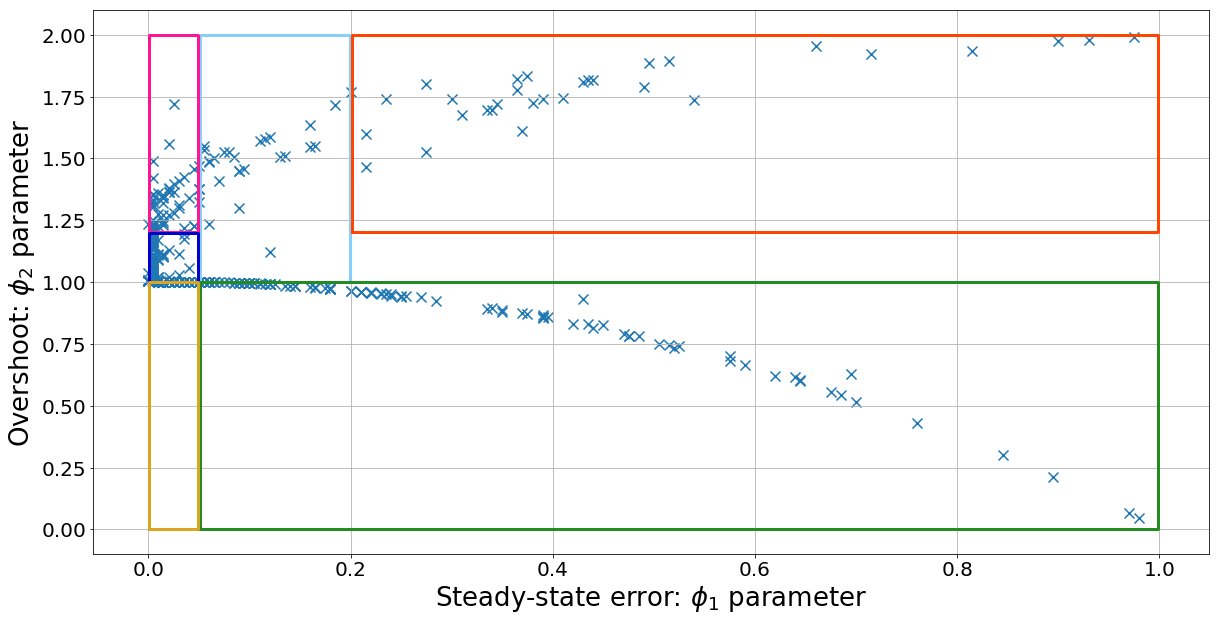

In [42]:
plt.figure(figsize=(20,10))
plt.scatter(settling, peak, marker="x", s = 100)
plt.grid(True)

δ = 0.01
really_underdamped_box = [0.2, 1, 1.2, 2.0]
underdamped_box = [0.05, 0.2, 1.0, 2.0]
well_damped_high_bump_box = [0.0, 0.05, 1.2, 2.0]
nice_responses = [0.0, 0.05, 1.0, 1.2]
over_damped_box = [0.05, 1.0, 0.0, 1.0]
over_damped_but_ok_box = [0.0, 0.05, 0.0, 1.0]

draw_box(underdamped_box, "lightskyblue", linewidth=3)
draw_box(really_underdamped_box, "orangered", linewidth=3)
draw_box(well_damped_high_bump_box, "deeppink", linewidth=3)
draw_box(nice_responses, "mediumblue", linewidth=3)
draw_box(over_damped_box, "forestgreen", linewidth=3)
draw_box(over_damped_but_ok_box, "goldenrod", linewidth=3)
plt.xlabel("Steady-state error: $\phi_1$ parameter", fontsize=fs)
plt.ylabel("Overshoot: $\phi_2$ parameter", fontsize=fs)

# plt.savefig("figs/clustering_boxes.png")

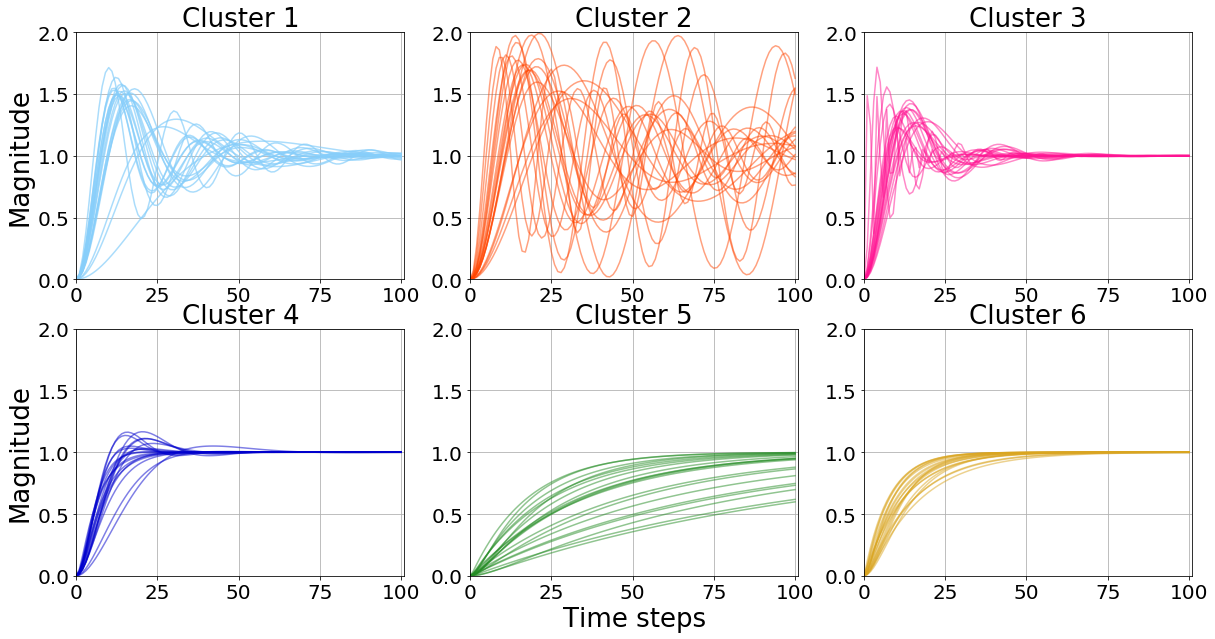

In [47]:
plt.figure(figsize=(20,10))
P = 20
fs = 26

n1, n2 = 2,3
plt.subplot(n1,n2,1)
plt.plot(ys_[[in_box(underdamped_box, settling[i], peak[i]) for i in range(N)],:][:P,:].T, c="lightskyblue", alpha=0.7)
plt.grid(True)
plt.xlim([0,101])
plt.ylim([0, 2])
plt.title("Cluster 1", fontsize=fs)
plt.ylabel("Magnitude", fontsize=fs)


plt.subplot(n1,n2,2)
plt.plot(ys_[[in_box(really_underdamped_box, settling[i], peak[i]) for i in range(N)],:][:P,:].T, c="orangered", alpha=0.5)
plt.grid(True)
plt.xlim([0,101])
plt.ylim([0, 2])
plt.title("Cluster 2", fontsize=fs)

plt.subplot(n1,n2,3)
plt.plot(ys_[[in_box(well_damped_high_bump_box, settling[i], peak[i]) for i in range(N)],:][:P,:].T, c="deeppink", alpha=0.5)
plt.grid(True)
plt.xlim([0,101])
plt.ylim([0, 2])
plt.title("Cluster 3", fontsize=fs)

plt.subplot(n1,n2,4)
plt.plot(ys_[[in_box(nice_responses, settling[i], peak[i]) for i in range(N)],:][:P,:].T, c="mediumblue", alpha=0.5)
plt.grid(True)
plt.xlim([0,101])
plt.ylim([0, 2])
plt.title("Cluster 4", fontsize=fs)
plt.ylabel("Magnitude", fontsize=fs)


plt.subplot(n1,n2,5)
plt.plot(ys_[[in_box(over_damped_box, settling[i], peak[i]) for i in range(N)],:][:P,:].T, c="forestgreen", alpha=0.5)
plt.grid(True)
plt.xlim([0,101])
plt.ylim([0, 2])
plt.title("Cluster 5", fontsize=fs)
plt.xlabel("Time steps", fontsize=fs)

plt.subplot(n1,n2,6)
plt.plot(ys_[[in_box(over_damped_but_ok_box, settling[i], peak[i]) for i in range(N)],:][:P,:].T, c="goldenrod", alpha=0.5)
plt.grid(True)
plt.xlim([0,101])
plt.ylim([0, 2])
plt.title("Cluster 6", fontsize=fs)


plt.savefig(fig_dir + "/clusters.png")

### Computation time comparison plot
Computation time is computed from running the `scripts/pstl.py`. To run all the functions automatically to record their computation time, run the `scripts/time_pstl.sh` script.

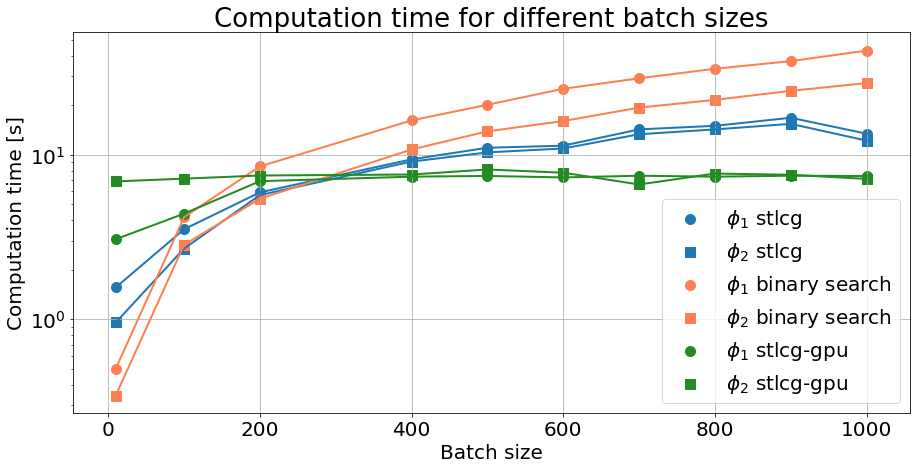

In [46]:
times = open(data_dir + "/compute_time.txt","r") 
time_mat = np.zeros([6,11])
m = {1:0, 10:1, 100:2, 200:3, 400:4, 500:5, 600:6, 700:7, 800:8, 900:9, 1000:10}
for l in times:
    line = l.split(' ')
    typ = int(line[2])
    signal_len = m[int(line[3])]
    num = float(line[4])
    tim = line[12].split(":")
    if len(tim) == 2:
        tt = float(tim[0])*60 + float(tim[1])
    else:
        tt = float(tim[0])
    time_mat[typ-1, signal_len] = tt/num
    

signal_lengths = [10, 100, 200, 400, 500, 600, 700, 800, 900, 1000]
plt.figure(figsize=(15, 7))
markersize = 100
linewidth = 2
fontsize = 20
plt.plot(signal_lengths, time_mat[0,1:], c='#1f77b4', linewidth=linewidth)
plt.scatter(signal_lengths, time_mat[0,1:], label="$\phi_1$ stlcg", c='#1f77b4', s=markersize)

plt.plot(signal_lengths, time_mat[2,1:], c='#1f77b4', linewidth=linewidth)
plt.scatter(signal_lengths, time_mat[2,1:], label="$\phi_2$ stlcg", c='#1f77b4', s=markersize, marker='s')

plt.plot(signal_lengths, time_mat[1,1:], c="coral", linewidth=linewidth)
plt.scatter(signal_lengths, time_mat[1,1:], label="$\phi_1$ binary search", c="coral", s=markersize)

plt.plot(signal_lengths, time_mat[3,1:], c="coral", linewidth=linewidth)
plt.scatter(signal_lengths, time_mat[3,1:], label="$\phi_2$ binary search", c="coral", s=markersize, marker='s')

plt.plot(signal_lengths, time_mat[4,1:], c="forestgreen", linewidth=linewidth)
plt.scatter(signal_lengths, time_mat[4,1:], label="$\phi_1$ stlcg-gpu", c="forestgreen", s=markersize)

plt.plot(signal_lengths, time_mat[5,1:], c="forestgreen", linewidth=linewidth)
plt.scatter(signal_lengths, time_mat[5,1:], label="$\phi_2$ stlcg-gpu", c="forestgreen", s=markersize, marker='s')

plt.legend(fontsize=fontsize)
plt.yscale("log")
plt.grid()

plt.xlabel("Batch size", fontsize=fontsize)
plt.ylabel("Computation time [s]", fontsize=fontsize)
plt.title("Computation time for different batch sizes", fontsize=fontsize+6)
plt.savefig(fig_dir + "/computation_time.png")